In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample

from scikitplot.metrics import plot_ks_statistic, plot_roc

In [3]:
%matplotlib inline
%load_ext watermark
%watermark -iv -psklearn,scikitplot

seaborn    0.9.0
matplotlib 3.0.2
numpy      1.15.4
pandas     0.24.0
sklearn 0.20.2
scikitplot 0.3.7


In [4]:
df = pd.read_pickle('../data/churn_cleaned.pkl')

# Make cohorts  
Churn is generally done as a cohort analysis -- customers who entered at the same time have experienced similar
ads, prices, and other exogenous events not recorded in the database. It tends to do a better job comparing apples to apples.

I know from EDA that the churn is not divided evenly by customer tenure, but I also don't want to make my
sample sizes too small. 

If I were a real cable company, there'd be plenty of data. But, I've only got 7000 rows from Kaggle. So, I'm
only going to make four cohorts. By dividing them by quartiles, I get even-sized cohorts at the expense of having
uniform bands of time per cohort.

My cohorts are 0 to 9 months, then 10 to 29, 30 to 55, and 56 to 72 months.

In [5]:
n_cohorts = 4 
tenure_c, bins = pd.qcut(df.tenure, n_cohorts, labels=range(n_cohorts), retbins=True)

In [6]:
tenure_c.value_counts()

0    1854
3    1755
2    1719
1    1715
Name: tenure, dtype: int64

In [7]:
bins

array([ 0.,  9., 29., 55., 72.])

In [8]:
pd.Series(bins).diff()

0     NaN
1     9.0
2    20.0
3    26.0
4    17.0
dtype: float64

In [9]:
df['tenure_c'] = tenure_c

In [10]:
cohort_table = pd.DataFrame(index=range(n_cohorts), columns=['min_tenure','max_tenure', 'name'])
g = df.groupby('tenure_c')
for i in range(n_cohorts):
    group = g.get_group(i)
    cohort_table.loc[i,'min_tenure'] = group['tenure'].min()
    cohort_table.loc[i,'max_tenure'] = group['tenure'].max()
cohort_table.name = cohort_table.min_tenure.astype(str) + " - " + cohort_table.max_tenure.astype(str) + " months"

In [11]:
cohorts = [ df.query(f"tenure_c == {i}") for i in range(n_cohorts) ]

In [12]:
for i,cohort in enumerate(cohorts):
    counts = cohort.Churn.value_counts()
    
    cohort_table.loc[i,'observations'] = cohort.shape[0]
    cohort_table.loc[i, 'churn_yes'] = counts['Yes']
    cohort_table.loc[i, 'churn_no'] = counts['No']

cohort_table['churn_pct'] = cohort_table['churn_yes'] / cohort_table['observations']
cohort_table

,min_tenure,max_tenure,name,observations,churn_yes,churn_no,churn_pct
0,0,9,0 - 9 months,1854.0,923.0,931.0,0.497843
1,10,29,10 - 29 months,1715.0,486.0,1229.0,0.283382
2,30,55,30 - 55 months,1719.0,324.0,1395.0,0.188482
3,56,72,56 - 72 months,1755.0,136.0,1619.0,0.077493


# Resampling for class imbalance

As can be seen in the above table, only the first cohort has balanced classes. Resampling will ensure better
model performance.

There are fancy resamplers out there to try if random resampling doesn't work, but it's quicker to start with that.

In [13]:
def resample_cohort( cohort, factor ):
    if factor > 1:
        subset = cohort.query('Churn == "Yes"')
        n_samples = subset.shape[0] * (factor - 1) # The original Y's are still in cohort
        new_samples = resample(subset.values, replace=True, n_samples=n_samples, random_state=123)
        cohorts[i] = pd.concat([cohort, pd.DataFrame(data=new_samples, columns=cohort.columns)], axis=0)
    return cohort

# Preprocessing

To preprocess, I'm one-hot encoding the categorical variables and using StandardScaler for the 
numerical features. 

For logistic regression, I don't want collinear features. I'm dropping "No internet service" everywhere
for that reason. i.e. "OnlineBackup_No internet service" and "DeviceProtection_No internet service" should
be exactly the same one-hot vector.

In [14]:
numerical = [ 'tenure', 'MonthlyCharges', 'TotalCharges']

def make_xy( data ):
    
    y = data.Churn.map(dict(Yes=1,No=0))
    X = data.drop(columns=['customerID','Churn','tenure_c'])
    
    cols = X.columns
    categorical = [ c for c in cols if c not in numerical ]
    
    X = pd.concat([X[numerical], pd.get_dummies(X[categorical])], axis=1)
    
    # need to drop one-hot variables with an eye towards preventing collinearity
    # in particular, the "No internet service" one-hot cols are all the same for each
    # internet service add on 
    collinear_cats = [c for c in X.columns if c.find("_No") != -1 ]
    X = X.drop(columns=collinear_cats)
    X = X.drop(columns=['gender_Female', 'SeniorCitizen_0', "Contract_Two year",
                       "PaymentMethod_Mailed check"])
    return X.copy(), y
    
def preprocess_cohort(cohort, factor):
    
    train, test = train_test_split(cohort,stratify=cohort.Churn)
    
    # only resample the training set to prevent data leakage
    train = resample_cohort( train, factor )
    
    ss = StandardScaler()
    ss.fit(train[numerical].astype(np.float))
    
    X_train, y_train = make_xy(train)
    X_test, y_test = make_xy(test)
    
    X_train[numerical] = ss.transform(X_train[numerical].astype(np.float))
    X_test[numerical] = ss.transform(X_test[numerical].astype(np.float))
    
    return X_train, X_test, y_train, y_test

# Utitility function to stash model results

This way I can compare my models side-by-side rather than one at a time

In [15]:
def save_result(clf, X_train, y_train, X_test, y_test):
    yhat = clf.predict(X_test)
    yproba = clf.predict_proba(X_test)
    return dict(
        cm=confusion_matrix(y_test, yhat),
        y=y_test,
        yhat=yhat,
        yproba=yproba,
        report=classification_report(y_test,yhat),
        train_score=clf.score(X_train, y_train),
        test_score=clf.score(X_test,y_test),
        clf=clf,
        cols=X_test.columns,
        xtest=X_test
    )

# Logistic Regression

In [16]:
factors = [1, 2, 4, 8]
scores = [0] * n_cohorts
for i,cohort,factor  in zip(range(n_cohorts), cohorts, factors):
    X_train, X_test, y_train, y_test = preprocess_cohort( cohort, factor )
    
    clf =  LogisticRegressionCV(max_iter=200, n_jobs=-1, solver='lbfgs', cv=4)
    clf.fit(X_train, y_train)
    
    scores[i] = save_result(clf, X_train, y_train, X_test, y_test)


# Random Forest

In [17]:
treescores = [0] * n_cohorts

for i,cohort,factor  in zip(range(n_cohorts), cohorts, factors):
    X_train, X_test, y_train, y_test = preprocess_cohort( cohort, factor )
    
    clf = GridSearchCV( RandomForestClassifier(),
                       dict( n_estimators=[15],
                             max_depth=[4,5,6], 
                             min_samples_split=[10,20],
                             min_samples_leaf=[5,10],
                             max_features=[4,5,6]
                            ),
                        iid=False,
                        cv = 4,
                        n_jobs = -1,
                        verbose = True
    )
    clf.fit(X_train, y_train)
    
    treescores[i] = save_result(clf, X_train, y_train, X_test, y_test)

Fitting 4 folds for each of 36 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 4 folds for each of 36 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 4 folds for each of 36 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 4 folds for each of 36 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:    1.1s finished


# Results

In [18]:
def plot_stuff( lr_result, tree_result):
    
    fig,axs = plt.subplots(1,2,sharey=True, figsize=(10,4))
    fig.suptitle('ROC curves')
    plot_roc( lr_result['y'], lr_result['yproba'], title="Logistic Regression",
             plot_micro=False, plot_macro=False, classes_to_plot=[1], ax=axs[0] ) 
    plot_roc( tree_result['y'], tree_result['yproba'], title="Random Forest",
             plot_micro=False, plot_macro=False, classes_to_plot=[1], ax=axs[1] ) 
    plt.show()
    
    fig,axs = plt.subplots(1,2,sharey=True, figsize=(10,4))
    fig.suptitle('K-S Statistic')
    plot_ks_statistic( lr_result['y'], lr_result['yproba'], title="Logistic Regression",
                          ax=axs[0] ) 
    plot_ks_statistic( tree_result['y'], tree_result['yproba'], title="Random Forest",
                          ax=axs[1] ) 
    plt.show()
    
def print_stuff( lr_result, tree_result, title ):
    print(title)
    print("Logistic Regression")
    print("\tTrain, test accuracy ", lr_result['train_score'], lr_result['test_score'])
    print("Confusion Matrix")
    print(lr_result['cm'])
    print(lr_result['report'])
    
    print("Random Forest")
    print("\tTrain, test accuracy ", tree_result['train_score'], tree_result['test_score'])
    print("Confusion Matrix")
    print(tree_result['cm'])
    print(tree_result['report'])

===== Cohort 0 : 0 - 9 months ====== 
Logistic Regression
	Train, test accuracy  0.7251798561151079 0.6831896551724138
Confusion Matrix
[[155  78]
 [ 69 162]]
              precision    recall  f1-score   support

           0       0.69      0.67      0.68       233
           1       0.68      0.70      0.69       231

   micro avg       0.68      0.68      0.68       464
   macro avg       0.68      0.68      0.68       464
weighted avg       0.68      0.68      0.68       464

Random Forest
	Train, test accuracy  0.7338129496402878 0.7112068965517241
Confusion Matrix
[[163  70]
 [ 64 167]]
              precision    recall  f1-score   support

           0       0.72      0.70      0.71       233
           1       0.70      0.72      0.71       231

   micro avg       0.71      0.71      0.71       464
   macro avg       0.71      0.71      0.71       464
weighted avg       0.71      0.71      0.71       464



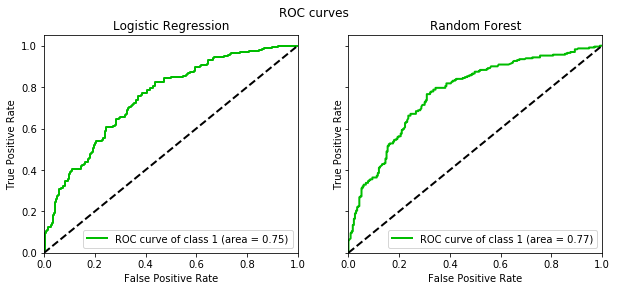

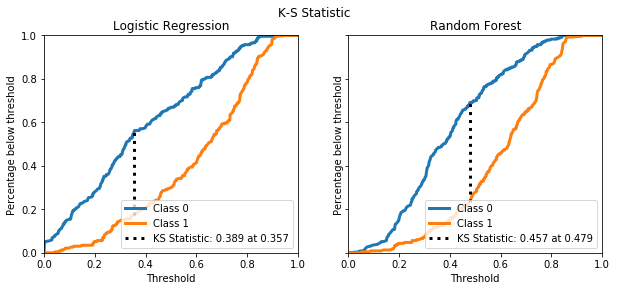

===== Cohort 1 : 10 - 29 months ====== 
Logistic Regression
	Train, test accuracy  0.7916018662519441 0.7738927738927739
Confusion Matrix
[[273  34]
 [ 63  59]]
              precision    recall  f1-score   support

           0       0.81      0.89      0.85       307
           1       0.63      0.48      0.55       122

   micro avg       0.77      0.77      0.77       429
   macro avg       0.72      0.69      0.70       429
weighted avg       0.76      0.77      0.76       429

Random Forest
	Train, test accuracy  0.8043654001616815 0.7651331719128329
Confusion Matrix
[[171  60]
 [ 37 145]]
              precision    recall  f1-score   support

           0       0.82      0.74      0.78       231
           1       0.71      0.80      0.75       182

   micro avg       0.77      0.77      0.77       413
   macro avg       0.76      0.77      0.76       413
weighted avg       0.77      0.77      0.77       413



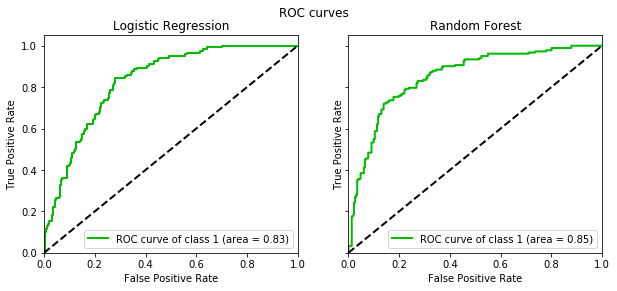

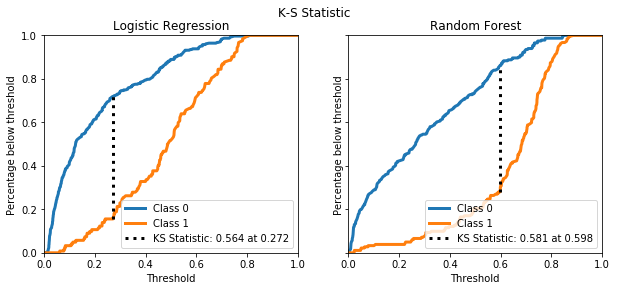

===== Cohort 2 : 30 - 55 months ====== 
Logistic Regression
	Train, test accuracy  0.8176881303335919 0.8418604651162791
Confusion Matrix
[[345   4]
 [ 64  17]]
              precision    recall  f1-score   support

           0       0.84      0.99      0.91       349
           1       0.81      0.21      0.33        81

   micro avg       0.84      0.84      0.84       430
   macro avg       0.83      0.60      0.62       430
weighted avg       0.84      0.84      0.80       430

Random Forest
	Train, test accuracy  0.8446794448116325 0.7861386138613862
Confusion Matrix
[[191  71]
 [ 37 206]]
              precision    recall  f1-score   support

           0       0.84      0.73      0.78       262
           1       0.74      0.85      0.79       243

   micro avg       0.79      0.79      0.79       505
   macro avg       0.79      0.79      0.79       505
weighted avg       0.79      0.79      0.79       505



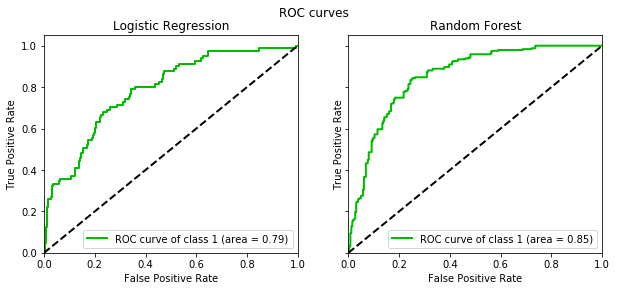

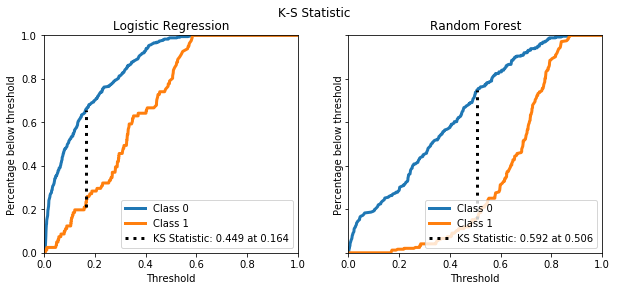

===== Cohort 3 : 56 - 72 months ====== 
Logistic Regression
	Train, test accuracy  0.9240121580547113 0.9179954441913439
Confusion Matrix
[[403   2]
 [ 34   0]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       405
           1       0.00      0.00      0.00        34

   micro avg       0.92      0.92      0.92       439
   macro avg       0.46      0.50      0.48       439
weighted avg       0.85      0.92      0.88       439

Random Forest
	Train, test accuracy  0.8823915900131406 0.8740157480314961
Confusion Matrix
[[254  50]
 [ 14 190]]
              precision    recall  f1-score   support

           0       0.95      0.84      0.89       304
           1       0.79      0.93      0.86       204

   micro avg       0.87      0.87      0.87       508
   macro avg       0.87      0.88      0.87       508
weighted avg       0.89      0.87      0.88       508



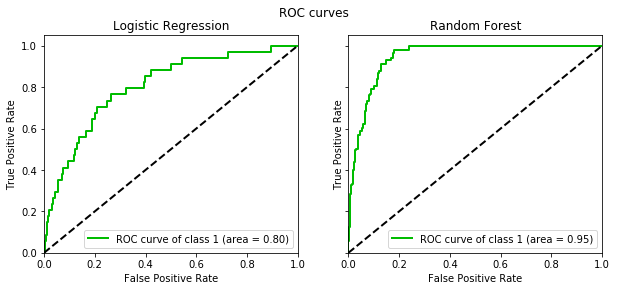

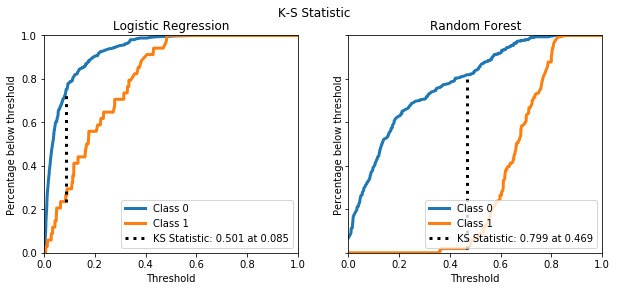

In [19]:
for i in range(n_cohorts):
    print_stuff(scores[i], treescores[i], f"===== Cohort {i} : {cohort_table.loc[i,'name']} ====== " )
    plot_stuff(scores[i], treescores[i])

Even with resampling the training data, the Logistic Regression model is not marking any of the test data in the last cohort as churn. 

# Feature coefficients (Logistic Regression)
Because Random Forest is throwing away features randomly under the covers, the default output for
feature_importance from sklearn is not reliable. For a short-term project, let's just look at the 
feature coefficients for the LR model.

In [20]:
for i in range(n_cohorts):
    print(f"===== Cohort {i} : {cohort_table.loc[i,'name']} ====== " )
    df = pd.DataFrame(data=scores[i]['clf'].coef_, columns=scores[i]['cols'], index=['coef']).T
    df['abs'] = df.eval('abs(coef)')
    top5 = df.sort_values('abs', ascending=False).head(5)[['coef']]
    print(top5)
    print("\n")

===== Cohort 0 : 0 - 9 months ====== 
                             coef
Contract_Month-to-month  5.539155
Contract_One year        4.413392
PhoneService_Yes        -1.321707
tenure                  -0.756875
MonthlyCharges           0.631575


===== Cohort 1 : 10 - 29 months ====== 
                                    coef
Contract_Month-to-month         1.012472
PhoneService_Yes               -0.784736
InternetService_Fiber optic     0.662033
PaymentMethod_Electronic check  0.607746
TechSupport_Yes                -0.490128


===== Cohort 2 : 30 - 55 months ====== 
                                 coef
Contract_Month-to-month      1.375223
PhoneService_Yes            -0.914419
InternetService_Fiber optic  0.841674
Contract_One year            0.714800
InternetService_DSL          0.627475


===== Cohort 3 : 56 - 72 months ====== 
                                    coef
PaymentMethod_Electronic check  0.966925
PhoneService_Yes               -0.966902
Contract_Month-to-month         0.7

In [21]:
scores[0]['xtest'][['MonthlyCharges', 'InternetService_Fiber optic']].corr()

,MonthlyCharges,InternetService_Fiber optic
MonthlyCharges,1.000000,0.837966
InternetService_Fiber optic,0.837966,1.000000


# Conclusions

Useful models were created for each cohort, with the Random Forest doing better overall. 

One thing I noticed while tuning the model was that monthly charges are higher for fiber optic customers.
During EDA, I treated 'monthly payment' and 'fiber optic' as separate features when in fact they are correlated.
The business needs to investigate how cost and product satisfaction issues affect the choice to drop the fiber optic service.

Because both "month to month" and "one year" contracts are important features in cohort 3, remember that
the two-year contract is lurking in there as well: It's not a label because I dropped one category from each one-hot encoded feature, 
but when both kept variables show up in feature importances, we're really selecting on the
third one as well. Similarly, "no internet service" is lurking as a predictor in cohort 2. 
 
One thing I missed during EDA was that having a phone line makes a customer less likely to churn compared to 
internet/TV only customers.

# Future work

A more logical cohort analysis would be splitting cohorts by contract type (a major predictor of churn) or product(s)
purchased (phone, internet, both) and then by years, so something like: 

   -  Month to month: less than one year, 1 to 2 years, 2 to 3 years, etc.
   -  One year contract: less than one year, 1 to 2 years, 2 to 3 years, etc.
   -  Two year contract: less than one year, 1 to 2 years, 2 to 3 years, etc.
   
Due to the relatively small dataset, it didn't make sense to slice-and-dice the data into too many pieces. Hence, my
choice to just make four cohorts by tenure quantiles.

One possible way to further tune the Logistic Regression classifier would be to run several bootstrapped copies
of the training data through a voting classifier to see if that makes the model less likely to chase noise.

The feature importance analysis is based on the model that performed less well: Need to do a proper test (such as a permutation
test or a model-based feature search) to extract the feature importance from the better performing Random Forest model. 